# House prediction


Cette fois, l'intérêt n'est plus de vous montrer la pipeline de ML mais de faire du ML à proprement parler ! 

Les données sont issues de Kaggle, disponibles sur [ce lien](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).


Elles comportent : 

- un ensemble d'entraînement (train.csv) à utiliser pour cross-valider les modèles 
- un ensemble de test (test.csv) à n'utiliser que pour la prédiction finale
- un dictionnaire de données (data_description.txt)

# 0. EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

X, y = df.drop(["SalePrice", "Id"], axis=1), df["SalePrice"]


Combien y a t il de colonnes ? et de lignes ? 

In [2]:
row, col = X.shape

print(f"Il y a {row} lignes et {col} colonnes")


Il y a 1460 lignes et 79 colonnes


Supprimer les colonnes avec plus de 10% de valeurs manquantes.

In [3]:
for col in X.columns:
    if X[col].isna().sum() > 146:
        X.drop(columns = col, inplace = True)

In [4]:
X.shape

(1460, 72)

Supprimer les lignes qui ont des valeurs manquantes parmi celles qui restent

In [5]:
X.dropna(inplace=True, axis = 0)

Ici, il ne reste plus de valeurs manquantes, dans le cas contraire, il aurait fallu utiliser : 
`.fillna` pour remplacer les quelques na qui seraient restés

On fait la même chose sur df :
- cela nous assure que y aura la même taille que X
- sans cela, on aura des prédictions sans queue ni tête, voire on ne pourra pas faire de régression linéaire car X et y n'auront pas la même taille

In [6]:
for col in df.columns:
    if df[col].isna().sum() > 146:
        df.drop(columns = col, inplace = True)

In [7]:
df.dropna(inplace = True, axis = 0)

In [8]:
df.shape

(1338, 74)

In [9]:
y = df["SalePrice"]

In [10]:
y.shape

(1338,)

In [11]:
X.shape

(1338, 72)

X et y ont bien la même taille

Quelles sont les colonnes numériques ? Et catégorielles ?  

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1338 non-null   int64  
 1   MSZoning       1338 non-null   object 
 2   LotArea        1338 non-null   int64  
 3   Street         1338 non-null   object 
 4   LotShape       1338 non-null   object 
 5   LandContour    1338 non-null   object 
 6   Utilities      1338 non-null   object 
 7   LotConfig      1338 non-null   object 
 8   LandSlope      1338 non-null   object 
 9   Neighborhood   1338 non-null   object 
 10  Condition1     1338 non-null   object 
 11  Condition2     1338 non-null   object 
 12  BldgType       1338 non-null   object 
 13  HouseStyle     1338 non-null   object 
 14  OverallQual    1338 non-null   int64  
 15  OverallCond    1338 non-null   int64  
 16  YearBuilt      1338 non-null   int64  
 17  YearRemodAdd   1338 non-null   int64  
 18  RoofStyle    

## Variables Catégorielles

Inspectez les variables catégorielles

In [13]:
X_cat = X.select_dtypes(include=['object'])

Pour plus de visibilité, on va s'intéresser à l'inspection de trois variables catégorielles : 
* MSZoning
* Utilities
* Neighborhood

<Figure size 1000x500 with 0 Axes>

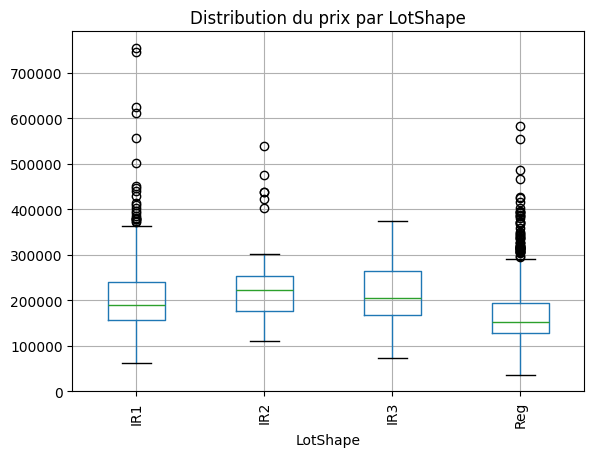

<Figure size 1000x500 with 0 Axes>

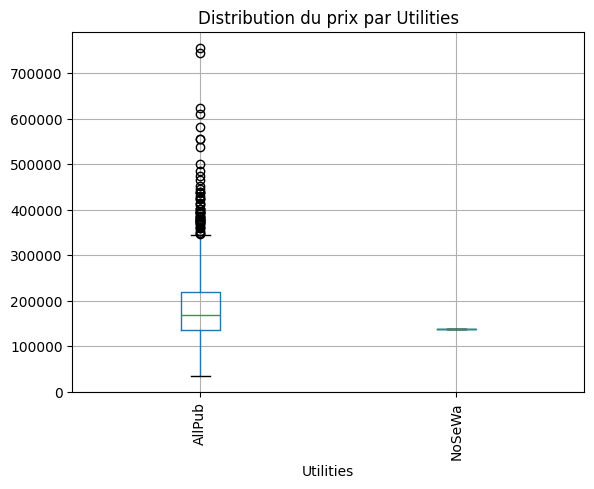

<Figure size 1000x500 with 0 Axes>

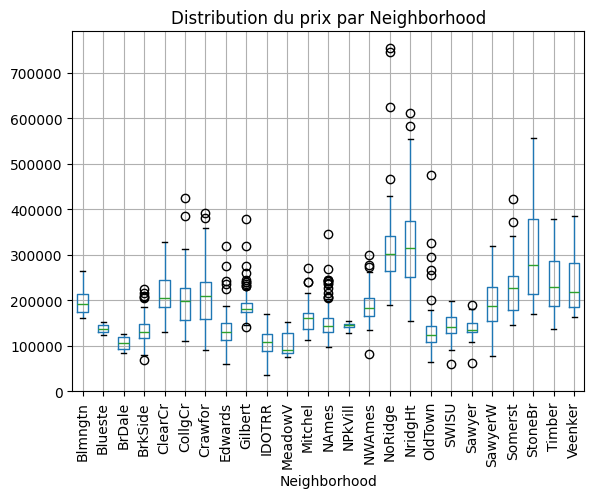

In [14]:
for col in ["LotShape", "Utilities", "Neighborhood"]:
    plt.figure(figsize=(10, 5))
    Xy = pd.concat([X_cat[col], y], axis=1)
    Xy.boxplot(column=y.name, by=col, rot=90)
    plt.suptitle("")
    plt.title(f"Distribution du prix par {col}")
    plt.show();


Les boxplots permettent de tirer quelques conclusions : 
* Si elle se ressemblent toutes, les catégories sont peu informatives (peut-être le cas pour `LotShape`)
* Le nombre de catégories différentes (par ex pour `Neighborhood`), couplé à des boxplots de plusieurs tailles et avec plus ou moins d'impacts sur les prix, peut être le signe d'une variable intéressante à conserver
* Inversement, une variable avec peu de catégories (comme `Utilities`), et avec peu ou pas de données pour certaines catégories, sont le signe de variables dont on peut se séparer

In [15]:
X_cat['Utilities'].value_counts(normalize = True)
# normalize = True permet d'afficher un %

Utilities
AllPub    0.999253
NoSeWa    0.000747
Name: proportion, dtype: float64

Dans le cas de la dernière hypothèse, utiliser value_counts permet de définitivement valider l'idée que la variable est inintéressante car trop peu informative, encore plus dans notre cas, où la catégorie NoSeWa ne de distingue pas par une modification particulière du prix. 

In [16]:
X_cat["LotShape"].value_counts(normalize=True)
# Ici de la même manière, modifier IR3 et IR2 en "rare" ?


LotShape
Reg    0.619581
IR1    0.343049
IR2    0.029895
IR3    0.007474
Name: proportion, dtype: float64

In [17]:
from scipy.stats import f_oneway


In [18]:
for col in ["LotShape", "Utilities", "Neighborhood"]:

    groups = [
        y[X[col] == cat]
        for cat in X[col].unique()
    ]

    f_stat, p_value = f_oneway(*groups)

    print(f"Pour la variable {col}, on trouve une p_value de {p_value}")

Pour la variable LotShape, on trouve une p_value de 3.761233246544098e-22
Pour la variable Utilities, on trouve une p_value de 0.5325118904312293
Pour la variable Neighborhood, on trouve une p_value de 1.2061203237612143e-193


Les p_values indiquent : 
* dans le cas où elles sont inférieures à 0.05, que la variable est informative
* dans le cas contraire, que la variable n'a pas ou peu d'impact

Enfin, la méthode scatter permet de visualiser les 2 premières méthodes "d'un seul coup"

LotShape


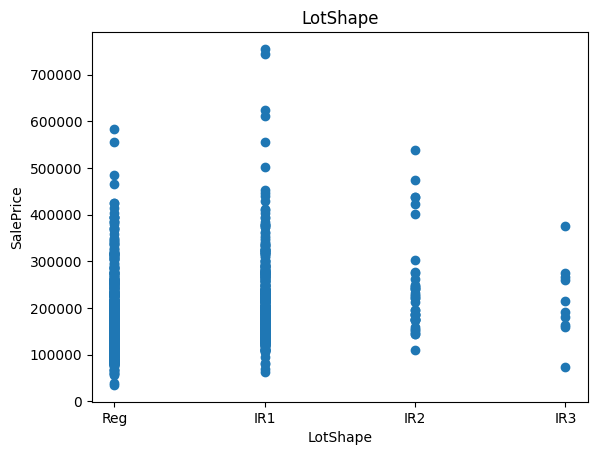

Utilities


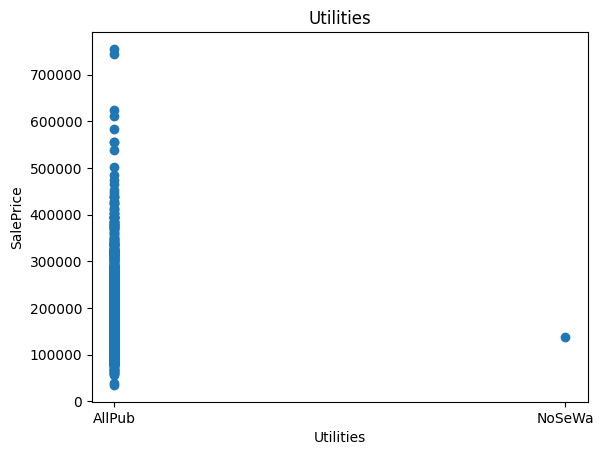

Neighborhood


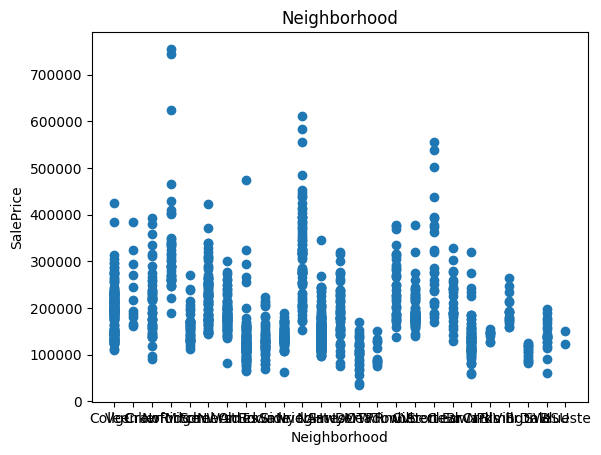

In [19]:
for col in ["LotShape", "Utilities", "Neighborhood"]:
    print(col)
    plt.scatter(X_cat[col], y)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("SalePrice")
    plt.show()

Quelles sont celles qui vous paraissent le plus informatives pour discriminer les prix de ventes ? 

- qui ont des valeurs de ventes différentes selon les catégories
- qui ont beaucoup de valeurs dans chaque catégories
- qui ont du sens d'après le dictionnaire de données ? 
- ne sont pas déjà prises en compte dans les variables quantitatives

Vous pouvez regarder l'association entre les variables pour enlever les variables redondantes.

In [20]:
from skrub import TableReport
# pip install skrub si vous ne l'avez pas déjà

TableReport(X_cat, max_plot_columns=30, max_association_columns=30)

Processing column  37 / 37


,,,,,,,,,,,,,,,


### Encoding des variables catégorielles

Gardez moins de 10 variables catégorielles et encodez les proprement avec `OneHotEncoder` ou `OrdinalEncoder`. 

Quelles colonnes catégorielles garder ? 

In [21]:
len(X_cat.columns)

37

In [22]:
col_kept = []
for col in X_cat.columns:
    groups = [
        y[X[col] == cat]
        for cat in X[col].unique()
    ]

    f_stat, p_value = f_oneway(*groups)
    if p_value < 0.05 :
        col_kept.append(col) # on ne garde que les variables catégorielles suffisamment informatives

In [23]:
len(col_kept)

32

#### 2 méthodes pour mesurer l'importance de nos variables catégorielles

##### Méthode 1 - mutual info regression

La mutual information mesure la quantité d’information qu’une variable X
apporte sur la cible y, sans supposer de relation linéaire.

Elle est utilisée pour classer les variables selon leur pouvoir prédictif
et constitue un excellent outil de sélection de variables, en particulier
pour les variables catégorielles.

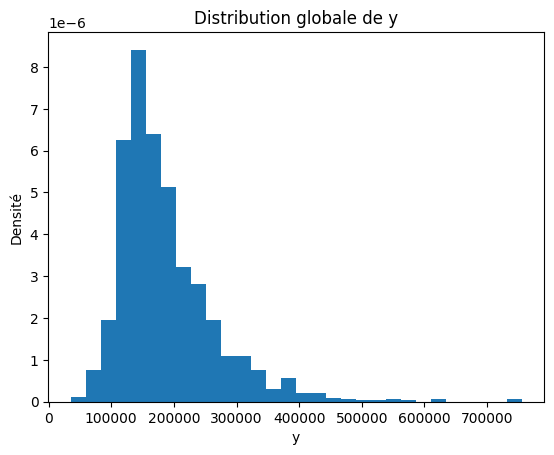

In [24]:
plt.figure()
plt.hist(y, bins=30, density=True)
plt.title("Distribution globale de y")
plt.xlabel("y")
plt.ylabel("Densité")
plt.show()


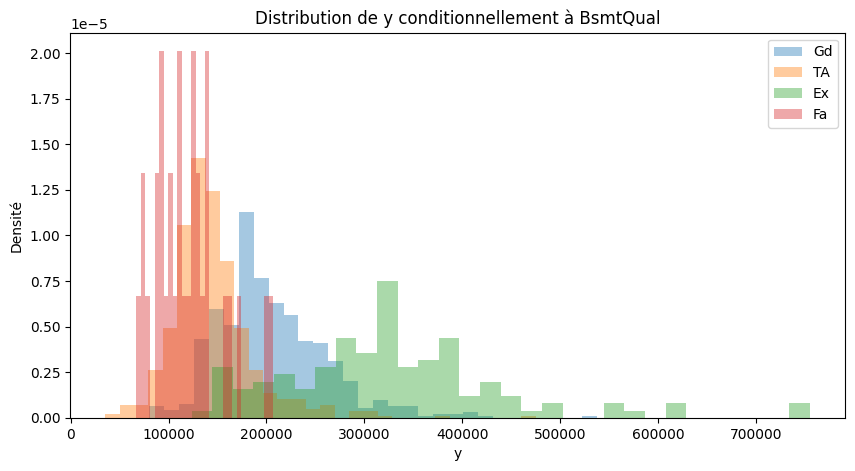

In [25]:
cat = "BsmtQual"

plt.figure(figsize=(10, 5))
for value in X[cat].unique():
    plt.hist(
        y[X[cat] == value],
        bins=30,
        density=True,
        alpha=0.4,
        label=value
    )

plt.title(f"Distribution de y conditionnellement à {cat}")
plt.xlabel("y")
plt.ylabel("Densité")
plt.legend()
plt.show()

In [26]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder

X_cat_encoded = OrdinalEncoder().fit_transform(X[col_kept])
# On utilise un OrdinalEncoder pour avoir une valeur "chiffrée" à donner au modèle

mi = mutual_info_regression(X_cat_encoded, y)

mi_scores = pd.Series(mi, index=col_kept).sort_values(ascending=False)

In [27]:
col_chosen = mi_scores.head(10).index.to_list()

##### Méthode 2, plus complexe : créer un arbre de probabilité et visualiser l'impact sur le prix de chaque "chemin"

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), col_kept)
    ]
)

X_cat_ohe = preprocessor.fit_transform(X)

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_cat_ohe, y)

ohe = preprocessor.named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(col_kept)

importances = pd.Series(
    rf.feature_importances_,
    index=feature_names
)

# regrouper par variable catégorielle
cat_importance = (
    importances
    .groupby(lambda x: x.split("_")[0])
    .sum()
    .sort_values(ascending=False)
)

cat_importance


ExterQual        0.338602
BsmtQual         0.141941
Neighborhood     0.109105
KitchenQual      0.084715
BsmtExposure     0.036707
GarageType       0.027451
Exterior2nd      0.023992
Exterior1st      0.023851
GarageFinish     0.022904
HouseStyle       0.020931
BsmtFinType1     0.016728
MSZoning         0.016437
LotShape         0.015387
BldgType         0.013210
LotConfig        0.013152
RoofStyle        0.012464
LandContour      0.011202
SaleCondition    0.010621
SaleType         0.008395
BsmtFinType2     0.007682
HeatingQC        0.007472
Condition1       0.005586
ExterCond        0.005391
RoofMatl         0.005104
Foundation       0.004396
GarageQual       0.003976
Functional       0.003342
BsmtCond         0.002811
CentralAir       0.002516
PavedDrive       0.001533
Electrical       0.001307
GarageCond       0.001088
dtype: float64

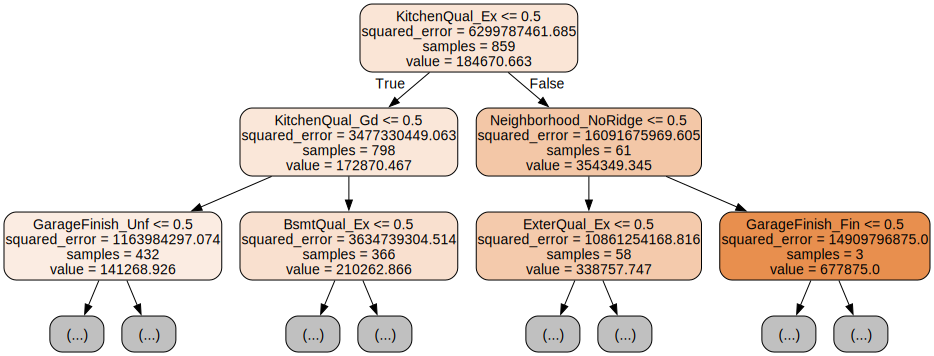

In [29]:
from sklearn.tree import export_graphviz
import graphviz

tree = rf.estimators_[0]
dot_data = export_graphviz(tree, feature_names=feature_names, filled=True, rounded=True, max_depth=2)
graphviz.Source(dot_data)


Restons sur les colonnes choisies grâce à `mutual_info_regression`

**Tracez les matrices de corrélation entre ces variables.**

Visualisons la corrélation entre les colonnes catégorielles et la variable cible SalesPrice de manière simple

La méthode la plus simple et compréhensible est la suivante : 
* pour chaque colonne, on calcul, par catégorie, la moyenne de SalePrice
* on utilise ensuite une matrice de corrélation (calculée avec `.corr` et le coefficient de Pearson)

Ici, il s'agit de vérifier que la corrélation entre nos variables choisies et la variable cible est bien supérieure à 0/suffisante pour conserver nos variables

In [30]:
df_corr = df.copy()

for col in col_chosen:
    df_corr[col] = df.groupby(col)['SalePrice'].transform('mean')
corr_matrix = df_corr[col_chosen + ["SalePrice"]].corr()


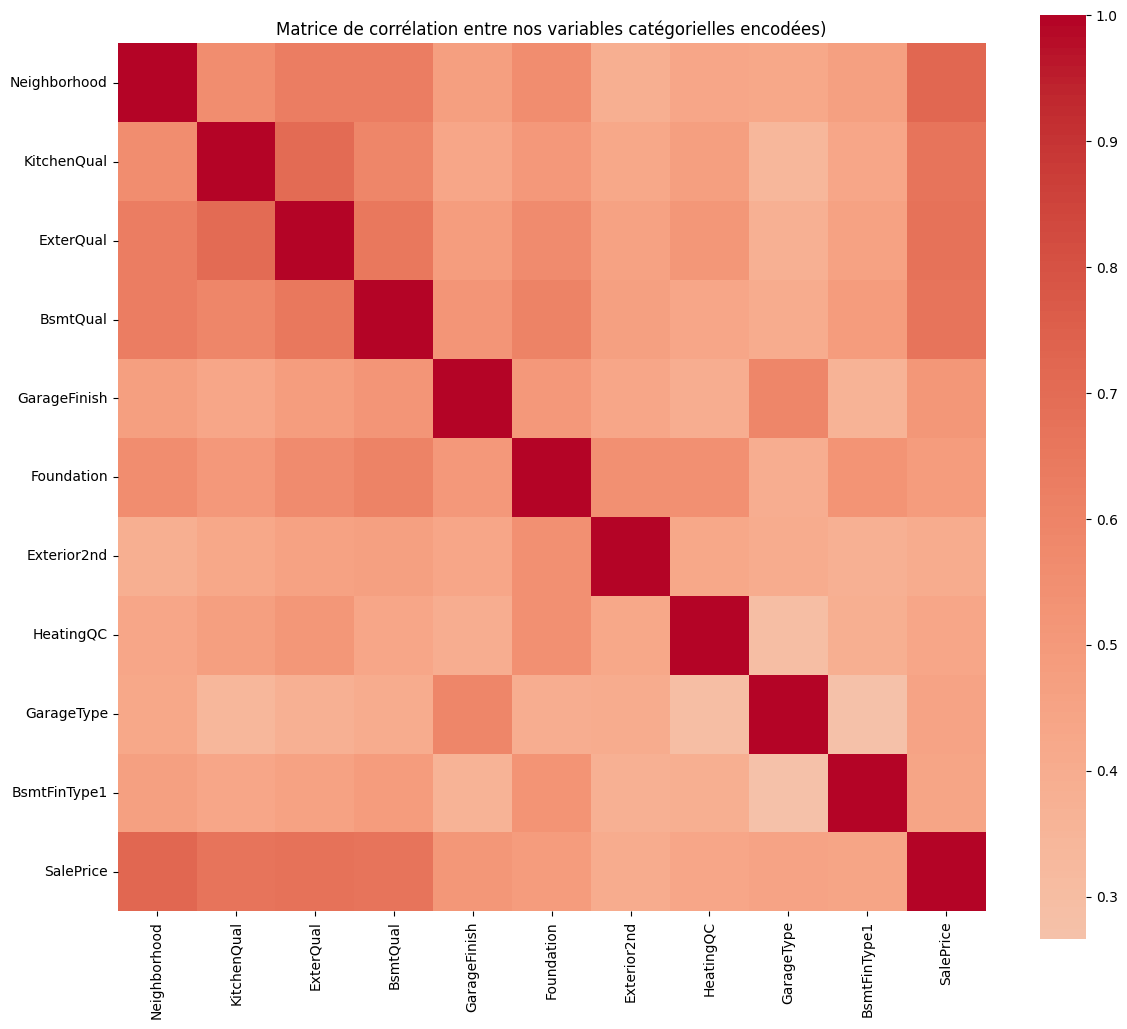

In [31]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True
)
plt.title("Matrice de corrélation entre nos variables catégorielles encodées)")
plt.show()


Ici, on peut voir aussi : 
* une forte corrélation entre tous les `qqchQual`, on va donc ne garder que `BsmtQual`
* de la même manière, `GarageFinish`et `GarageType`sont très corrélés, ne gardons donc que l'un des deux

In [32]:
col_chosen.remove("ExterQual")
col_chosen.remove("KitchenQual")
col_chosen.remove("GarageType")

In [33]:
col_chosen

['Neighborhood',
 'BsmtQual',
 'GarageFinish',
 'Foundation',
 'Exterior2nd',
 'HeatingQC',
 'BsmtFinType1']

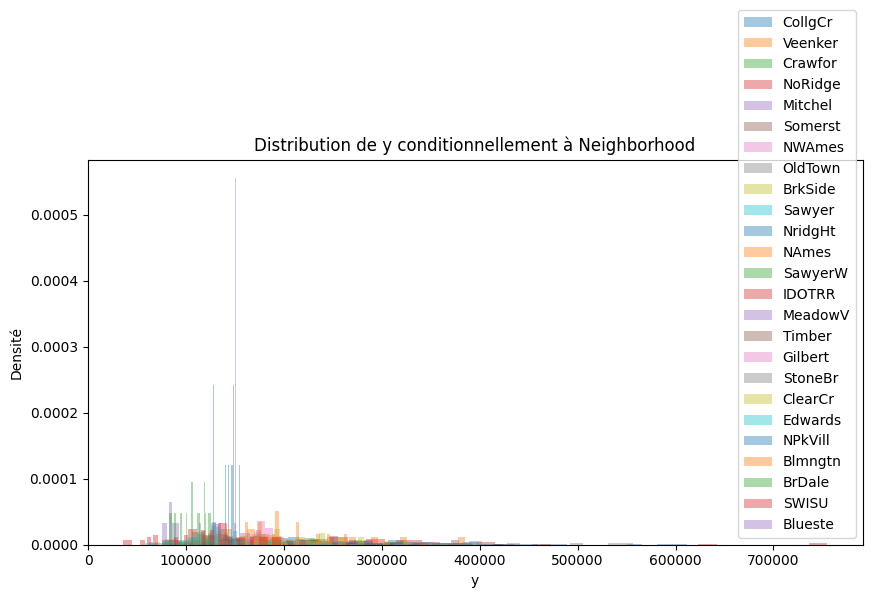

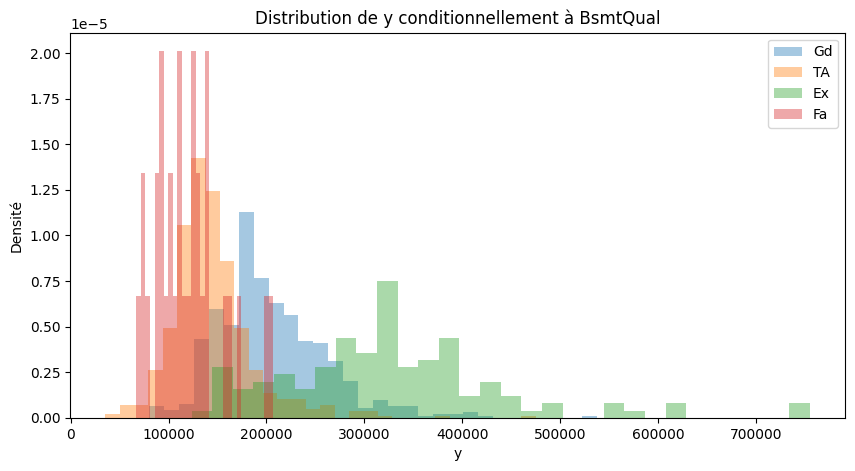

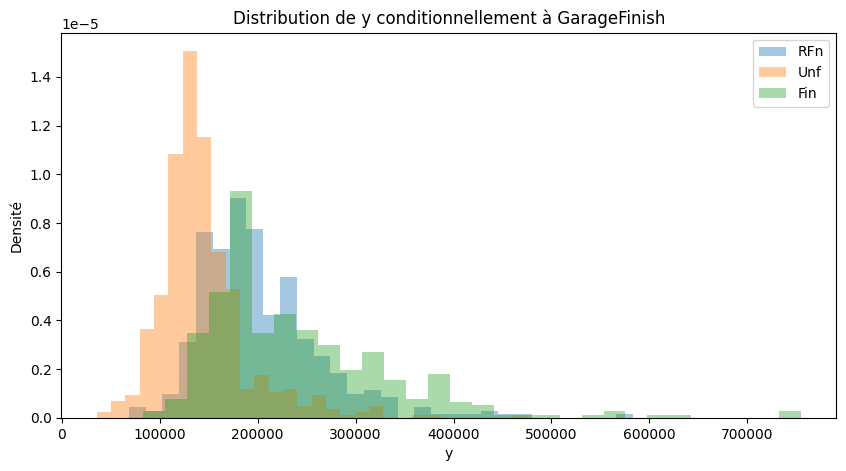

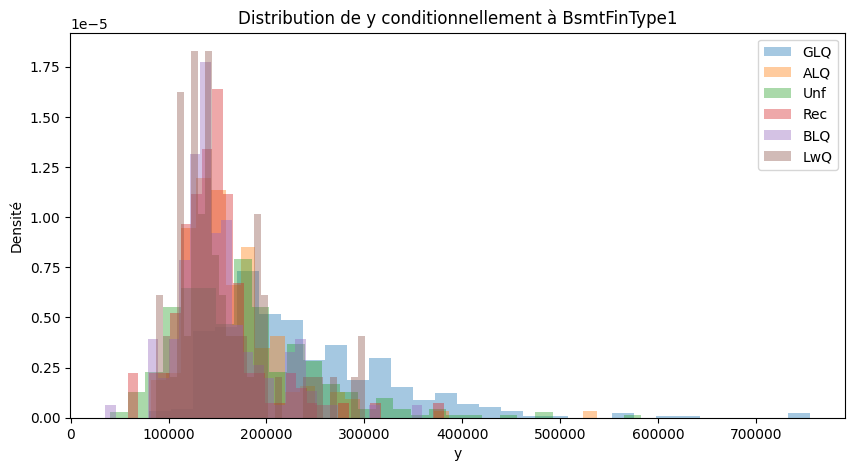

In [34]:
for cat in ["Neighborhood", "BsmtQual", "GarageFinish", "BsmtFinType1"]:
    plt.figure(figsize=(10, 5))
    for value in X[cat].unique():
        plt.hist(
            y[X[cat] == value],
            bins=30,
            density=True,
            alpha=0.4,
            label=value
        )

    plt.title(f"Distribution de y conditionnellement à {cat}")
    plt.xlabel("y")
    plt.ylabel("Densité")
    plt.legend()
    plt.show()

On décide : 
* d'OrdinalEncoder : `BsmtQual`, `GarageFinish`
* de OneHotEncoder les autres

In [35]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# colonne à ordinal encoder
col_oc = ['BsmtQual', 'GarageFinish']
# ordre d'encodage
bsmtqual_order = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
garagefinish_order = ['Unf', 'RFn', 'Fin']

col_ohe = [
    'Neighborhood',
    'Foundation',
    'Exterior2nd',
    'HeatingQC',
    'MSZoning'
    ]

Ex de ce à quoi cela va ressembler dans les faits

In [36]:
X_one_hot_encoded = X[["Neighborhood"]]

In [37]:
enc_one_hot = OneHotEncoder(sparse_output=False)
enc_one_hot.fit_transform(X_one_hot_encoded.head(15).values.reshape(-1, 1))


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
X_ordinal_encoded = X[["GarageFinish"]]
enc_ord = OrdinalEncoder(categories=[garagefinish_order])
enc_ord.fit_transform(X_ordinal_encoded.head(15).values.reshape(-1,1))

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [2.],
       [0.],
       [1.],
       [1.]])

### Variables numériques

On fait la même chose pour les variables numériques

In [39]:
df_num = df.select_dtypes(include=["int64", "float64"])

corr_matrix = df_num.corr()

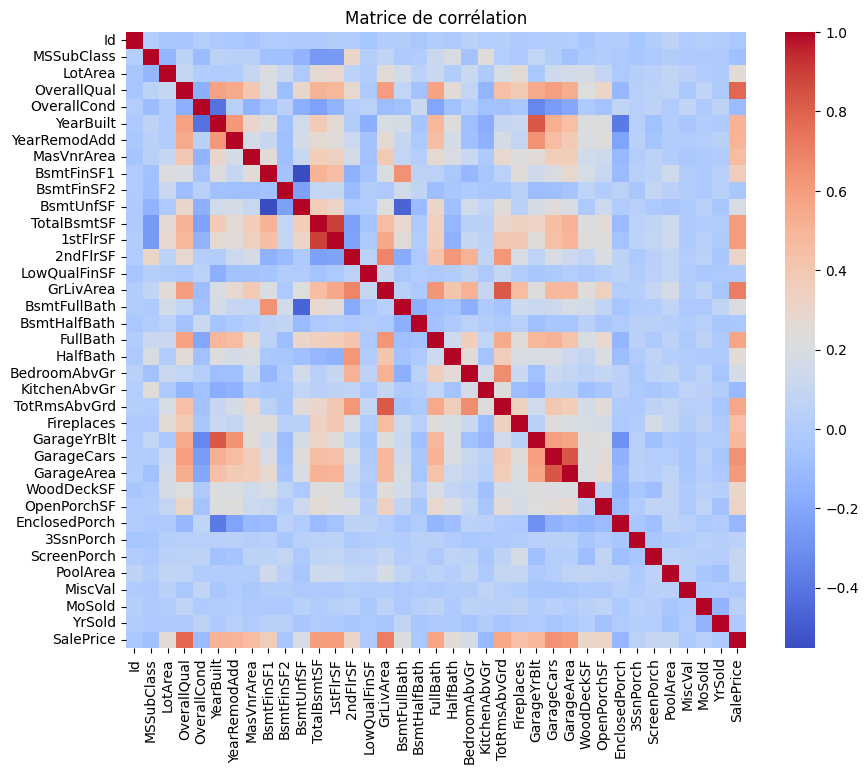

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()


In [41]:
corr_with_target = corr_matrix["SalePrice"].sort_values(ascending=False)

corr_with_target


SalePrice        1.000000
OverallQual      0.783546
GrLivArea        0.711706
GarageCars       0.640154
GarageArea       0.607535
1stFlrSF         0.604714
TotalBsmtSF      0.602042
FullBath         0.569313
TotRmsAbvGrd     0.551821
YearBuilt        0.504297
YearRemodAdd     0.501435
GarageYrBlt      0.481730
MasVnrArea       0.465811
Fireplaces       0.445434
BsmtFinSF1       0.359677
OpenPorchSF      0.322786
2ndFlrSF         0.311354
WoodDeckSF       0.305983
HalfBath         0.258175
LotArea          0.254757
BsmtFullBath     0.209695
BsmtUnfSF        0.191689
BedroomAbvGr     0.169266
ScreenPorch      0.096624
PoolArea         0.091881
3SsnPorch        0.042159
MoSold           0.041310
LowQualFinSF    -0.009992
MiscVal         -0.016990
YrSold          -0.020451
BsmtHalfBath    -0.030175
Id              -0.030473
BsmtFinSF2      -0.031226
MSSubClass      -0.079599
OverallCond     -0.108627
KitchenAbvGr    -0.111408
EnclosedPorch   -0.127385
Name: SalePrice, dtype: float64

Dans notre cas, toujours dans le but de rendre le modèle le plus interprétable possible, on va retirer toutes les valeurs qui ont une corrélation inférieure à 0.4 avec la variable cible

In [42]:
important_num_features = corr_with_target[abs(corr_with_target) > 0.4].drop('SalePrice', errors = 'ignore').index.tolist()

A quoi vont ressembler nos colonnes numériques encodées avec un StandardScaler ? 

In [43]:
from sklearn.preprocessing import StandardScaler
num_scaler = StandardScaler()

In [44]:
X_num = X[["OverallQual"]]

num_scaler.fit_transform(X_num.head(15).values.reshape(-1,1))

array([[ 0.33333333],
       [-0.5       ],
       [ 0.33333333],
       [ 0.33333333],
       [ 1.16666667],
       [-1.33333333],
       [ 1.16666667],
       [ 0.33333333],
       [ 0.33333333],
       [-1.33333333],
       [-1.33333333],
       [ 2.        ],
       [-1.33333333],
       [ 0.33333333],
       [-0.5       ]])

### Look of our final dataset

What does our reduced dataset look like now ? 

In [45]:
important_num_features

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 '1stFlrSF',
 'TotalBsmtSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'Fireplaces']

In [46]:
important_num_features.remove("YearBuilt")
important_num_features.remove("YearRemodAdd")
important_num_features.remove("GarageYrBlt")
# to be StandardScaled

In [47]:
col_oc # avec OrdinalEncoder
col_ohe # avec OneHotEncoder

['Neighborhood', 'Foundation', 'Exterior2nd', 'HeatingQC', 'MSZoning']

In [48]:
all_cols_kept = important_num_features + col_ohe + col_oc

In [49]:
X[all_cols_kept]

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,TotalBsmtSF,FullBath,TotRmsAbvGrd,MasVnrArea,Fireplaces,Neighborhood,Foundation,Exterior2nd,HeatingQC,MSZoning,BsmtQual,GarageFinish
0,7,1710,2,548,856,856,2,8,196.0,0,CollgCr,PConc,VinylSd,Ex,RL,Gd,RFn
1,6,1262,2,460,1262,1262,2,6,0.0,1,Veenker,CBlock,MetalSd,Ex,RL,Gd,RFn
2,7,1786,2,608,920,920,2,6,162.0,1,CollgCr,PConc,VinylSd,Ex,RL,Gd,RFn
3,7,1717,3,642,961,756,1,7,0.0,1,Crawfor,BrkTil,Wd Shng,Gd,RL,TA,Unf
4,8,2198,3,836,1145,1145,2,9,350.0,1,NoRidge,PConc,VinylSd,Ex,RL,Gd,RFn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,1647,2,460,953,953,2,7,0.0,1,Gilbert,PConc,VinylSd,Ex,RL,Gd,RFn
1456,6,2073,2,500,2073,1542,2,7,119.0,2,NWAmes,CBlock,Plywood,TA,RL,Gd,Unf
1457,7,2340,1,252,1188,1152,2,9,0.0,2,Crawfor,Stone,CmentBd,Ex,RL,TA,RFn
1458,5,1078,1,240,1078,1078,1,5,0.0,0,NAmes,CBlock,MetalSd,Gd,RL,TA,Unf


### Final Cleaning to get rid of outliers

On considère que dans un dataset normal, 5% des données sont des outliers.

Vous pouvez les enlever avec `sklearn.ensemble.IsolationForest`.

In [50]:
from sklearn.ensemble import IsolationForest

In [51]:
X_iso = df[["OverallQual", "SalePrice"]]
iso = IsolationForest(contamination=0.05, random_state=42)  # ~5% d'outliers
iso.fit(X_iso)
y_pred = iso.predict(X_iso)

X_normal = X_iso[y_pred == 1]
X_outliers = X_iso[y_pred == -1]


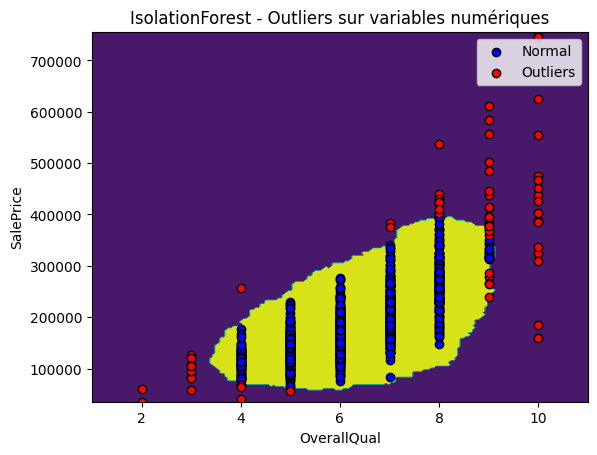

In [52]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# Affichage de la frontière
disp = DecisionBoundaryDisplay.from_estimator(
    iso, X_iso, response_method="predict", grid_resolution=200
)

plt.scatter(X_normal.iloc[:, 0], X_normal.iloc[:, 1], c='blue', edgecolor='k', label='Normal')
plt.scatter(X_outliers.iloc[:, 0], X_outliers.iloc[:, 1], c='red', edgecolor='k', label='Outliers')
plt.legend()
plt.title("IsolationForest - Outliers sur variables numériques")
plt.show()


In [53]:
import numpy as np
iso = IsolationForest(contamination=0.05, random_state=42)
iso.fit(df[important_num_features])  # Seules les colonnes importantes
y_pred = iso.predict(df[important_num_features])

# 1 = normal, -1 = outlier
outlier_index = np.where(y_pred == -1)[0]
print("Indices des outliers détectés :", outlier_index)


Indices des outliers détectés : [  11   50   55   67   95  108  125  145  148  160  166  203  213  243
  253  277  278  281  292  319  332  345  402  437  455  474  481  532
  533  535  558  586  595  605  619  632  657  682  704  731  736  758
  826  844  898  937  954  955  968 1005 1044 1070 1081 1083 1089 1104
 1124 1160 1188 1234 1237 1244 1257 1269 1287 1298 1309]


In [54]:
df.index = range(df.shape[0])
y.index = range(y.shape[0])

In [55]:
X_clean = df.drop(index=outlier_index, columns="SalePrice").reset_index(drop=True)
y_clean = y.drop(index=outlier_index).reset_index(drop=True)

# 1. Feature engineering

Normalisez (au sens de rendre normal / gaussien) les dimensions trop asymétriques (*skewness*) pour favoriser la régression linéaire : a minima la target **SalePrice** et les features d'aire (avec SF dedans).

In [56]:
y_log = np.log(y_clean)

Créez de nouvelles variables représentant :

- l’âge du bien au moment de la vente ;
  
- l’âge depuis la dernière rénovation ;
  
- l’âge du garage au moment de la vente ;
  
- et l’ancienneté de la transaction par rapport à l’année de référence du dataset (2010)

In [57]:
df["AgeAtSale"] = df["YrSold"] - df["YearBuilt"]
df["YearsSinceRemod"] = df["YrSold"] - df["YearRemodAdd"]
df["GarageAgeAtSale"] = df["YrSold"] - df["GarageYrBlt"]
df["SaleRecency"] = 2010 - df["YrSold"]
new_col = ["AgeAtSale", "YearsSinceRemod", "GarageAgeAtSale", "SaleRecency"]

# 2. Modélisation

## Train Test Split

Maintenant qu'on a traité X, qu'on a créé de nouvelles variables informatives, qu'on s'est séparé des variables non-informatives, il nous faut évaluer les modèles que l'on va créer en utilisant train_test_split et de la cross_validation

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, train_size=0.8, random_state=42)

## Baseline

Créez une baseline avec un `DummyRegressor`

In [59]:
from sklearn.dummy import DummyRegressor

y_train_log = np.log(y_train)

dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train_log)

,strategy,'mean'
,constant,None
,quantile,None


In [60]:
# Prédictions sur l'ensemble X_train
y_pred_train = dr.predict(X_train)
y_pred_train_orig = np.exp(y_pred_train)

# Prédictions sur l'ensemble X_test
y_pred = dr.predict(X_test)
y_pred_orig = np.exp(y_pred)


In [61]:
from sklearn.metrics import root_mean_squared_error
rmse_train = root_mean_squared_error(y_pred_train_orig, y_train)
rmse_test = root_mean_squared_error(y_pred_orig, y_test)

print(f"RMSE train is {rmse_train}$")
print(f"RMSE test is {rmse_test}$")

RMSE train is 63625.261471589714$
RMSE test is 66117.9550908053$


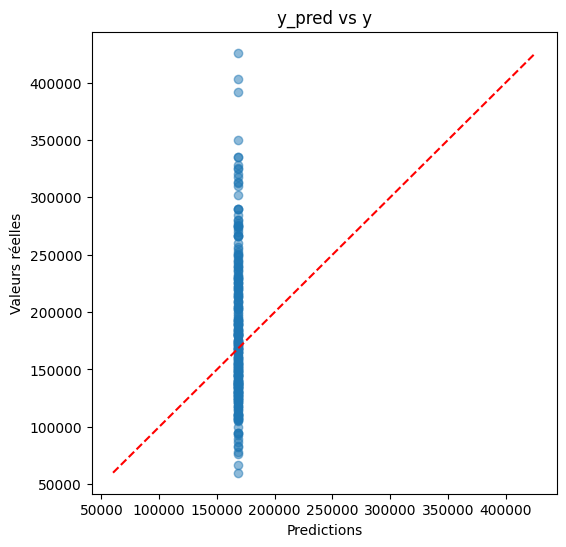

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_pred_orig, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # ligne y=x
plt.xlabel("Predictions")
plt.ylabel("Valeurs réelles")
plt.title("y_pred vs y")
plt.show()


## Cross Validation

Cross validez une régression linéaire simple

### Creation de transformers

Maintenant qu'on a fait tout le travail préliminaire, il nous faut faire un pipeline robuste (ie qu'on peut appliquer directement à test et à train)

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, reference_year=2010):
        self.reference_year = reference_year

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X["AgeAtSale"] = (X["YrSold"] - X["YearBuilt"]).clip(lower=0)
        X["YearsSinceRemod"] = (X["YrSold"] - X["YearRemodAdd"]).clip(lower=0)
        X["GarageAgeAtSale"] = (X["YrSold"] - X["GarageYrBlt"]).clip(lower=0)
        X["SaleRecency"] = (self.reference_year - X["YrSold"]).clip(lower=0)

        return X.drop(columns = ["YrSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt"])

class CleaningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, all_cols_kept, new_cols):
        self.all_cols_kept = all_cols_kept
        self.new_cols = new_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        cols_to_keep = [col for col in self.all_cols_kept + self.new_cols if col in X.columns]
        return X[cols_to_keep]


In [64]:
X_transformed = CleaningTransformer(all_cols_kept, new_col).fit_transform(AgeFeaturesTransformer().fit_transform(X_train))

In [65]:
X_transformed.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,1stFlrSF,TotalBsmtSF,FullBath,TotRmsAbvGrd,MasVnrArea,Fireplaces,...,Foundation,Exterior2nd,HeatingQC,MSZoning,BsmtQual,GarageFinish,AgeAtSale,YearsSinceRemod,GarageAgeAtSale,SaleRecency
156,7,1217,2,497,1217,1188,2,6,0.0,0,...,PConc,HdBoard,Ex,RL,Gd,Unf,19,18,19.0,1
1159,4,816,1,288,816,816,1,3,0.0,1,...,CBlock,MetalSd,Ex,RL,TA,Unf,71,51,51.0,1
1151,6,1478,2,442,1478,1478,1,6,0.0,2,...,CBlock,BrkFace,Gd,RL,TA,RFn,52,52,52.0,1
277,7,2978,2,564,1898,710,2,11,300.0,1,...,CBlock,Wd Sdng,Ex,RL,Gd,Fin,43,3,49.0,0
767,5,864,1,336,864,864,1,6,90.0,0,...,CBlock,VinylSd,Ex,RL,TA,Unf,31,4,31.0,1


### Pipeline

In [66]:
# On crée d'abord un preprocessor et une pipeline avant d'encoder les variables

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_col = X_transformed.select_dtypes(include = "number").columns.tolist()
num_scaler = StandardScaler()

ohe_col = col_ohe
ohe_enc = OneHotEncoder(handle_unknown="ignore")

col_garage = ["GarageFinish"]
garage_enc = OrdinalEncoder(
    categories=[garagefinish_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )

col_bsmt = ["BsmtQual"]
bsmt_enc = OrdinalEncoder(
    categories=[bsmtqual_order],
    handle_unknown='use_encoded_value',
    unknown_value=-1
    )

preprocessor = ColumnTransformer(
    transformers = [("num", num_scaler, num_col),
                    ("cat", OneHotEncoder(handle_unknown="ignore"), ohe_col),
                    ("garage", garage_enc, col_garage),
                    ("bsmt", bsmt_enc, col_bsmt),
                    ],
                    remainder="passthrough"
)

pipe = make_pipeline(
    AgeFeaturesTransformer(reference_year=2010),
    CleaningTransformer(all_cols_kept, new_col),
    preprocessor,
    LinearRegression()
    )

#### Petite subtilité liée au log

In [67]:
from sklearn.compose import TransformedTargetRegressor

reg = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log,
    inverse_func=np.exp
)

In [68]:
from sklearn.model_selection import cross_validate, RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5)


scores = cross_validate(
    reg,
    X = X_clean,
    y = y_clean,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    cv = cv,
    return_train_score=True
               )

# calcul des erreurs moyennes
train_mse = -np.mean(scores["train_score"])
test_mse = -np.mean(scores["test_score"])

# calcul des écarts-types
train_std = np.std(scores["train_score"])
test_std = np.std(scores["test_score"])

print("Cross-validated Train RMSE: {:.5f} +/- {:.5f}".format(train_mse, train_std))
print("Cross-validated Test RMSE: {:.5f} +/- {:.5f}".format(test_mse, test_std))

Cross-validated Train RMSE: 21574.67953 +/- 581.97011
Cross-validated Test RMSE: 23165.47858 +/- 2327.75598


In [69]:
pipe.fit(X_train, y_train_log)

,steps,"[('agefeaturestransformer', ...), ('cleaningtransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,reference_year,2010
,all_cols_kept,"['OverallQual', 'GrLivArea', ...]"
,new_cols,"['AgeAtSale', 'YearsSinceRemod', ...]"
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None


In [70]:
# Prédictions sur l'ensemble X_test
y_pred = pipe.predict(X_test)
y_pred_orig = np.exp(y_pred)

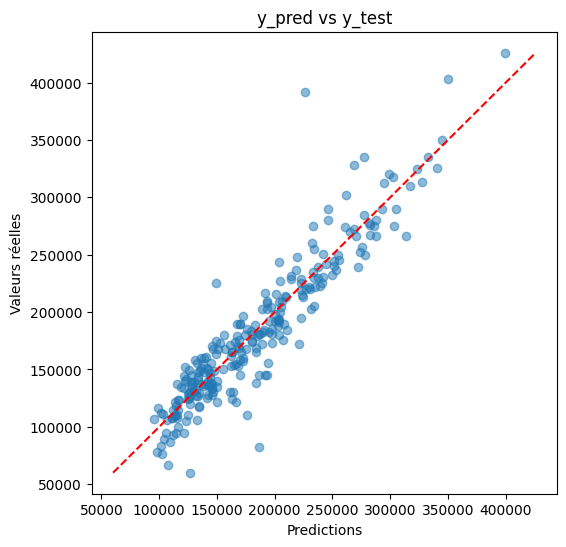

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_pred_orig, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # ligne y=x
plt.xlabel("Predictions")
plt.ylabel("Valeurs réelles")
plt.title("y_pred vs y_test")
plt.show()


## Optimisation d'un ElasticNet grâce à GridSearch

Performez une gridsearch en régularisant avec des pénalités L1 et L2 avec `ElasticNet`.

In [72]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    AgeFeaturesTransformer(reference_year=2010),
    CleaningTransformer(all_cols_kept, new_col),
    preprocessor,
    ElasticNet(max_iter=10000, random_state=42)
)

param_grid = {
    "regressor__elasticnet__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "regressor__elasticnet__l1_ratio": [0.001, 0.25, 0.5, 0.75, 1]
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

reg = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log,
    inverse_func=np.exp
)

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_clean, y_clean)

print("Meilleur alpha :", grid.best_params_["regressor__elasticnet__alpha"])
print("Meilleur l1_ratio :", grid.best_params_["regressor__elasticnet__l1_ratio"])
print("Best RMSE :",  - grid.best_score_)

# Prédictions sur train ou test
y_pred = grid.predict(X)


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Meilleur alpha : 0.001
Meilleur l1_ratio : 0.001
Best RMSE : 23144.007601282254


In [73]:
pipe = make_pipeline(
    AgeFeaturesTransformer(reference_year=2010),
    CleaningTransformer(all_cols_kept, new_col),
    preprocessor,
    ElasticNet(max_iter=10000, alpha=0.001, l1_ratio=0.001, random_state=42)
)
pipe.fit(X_train, y_train_log)


,steps,"[('agefeaturestransformer', ...), ('cleaningtransformer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,reference_year,2010
,all_cols_kept,"['OverallQual', 'GrLivArea', ...]"
,new_cols,"['AgeAtSale', 'YearsSinceRemod', ...]"
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None


In [74]:
# Prédictions sur le train et le test
y_pred_train = pipe.predict(X_train)
y_pred_train_orig = np.exp(y_pred_train)
y_pred = pipe.predict(X_test)
y_pred_orig = np.exp(y_pred)

print(f"RMSE train is {rmse_train}$")
print(f"RMSE test is {rmse_test}$")


RMSE train is 63625.261471589714$
RMSE test is 66117.9550908053$


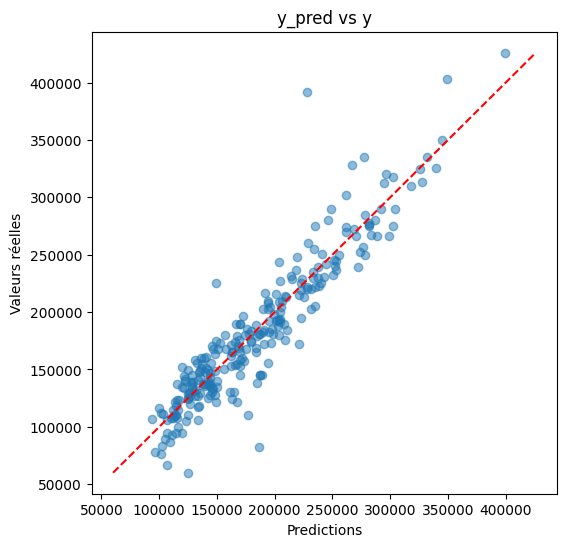

In [75]:
plt.figure(figsize=(6,6))
plt.scatter(y_pred_orig, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")  # ligne y=x
plt.xlabel("Predictions")
plt.ylabel("Valeurs réelles")
plt.title("y_pred vs y")
plt.show()

# 3. Final push

Une fois satisfait du modèle, il ne nous reste qu'à faire deux choses : 
* Entraîner sur toutes les données d'entraînement
* Prédire le vrai test.csv --> et rentrer les données dans l'éventuel kaggle/notre modèle de prédiction

In [76]:
# On entraîne sur toutes les données à notre disposition
pipe.fit(X_clean, np.log(y_clean))

X_test_final = pd.read_csv("test.csv")

In [77]:
y_pred_final = pipe.predict(X_test_final)

y_pred_final = np.exp(y_pred_final)

In [78]:
y_pred_final

array([111236.79034221, 138841.63057479, 173870.53317057, ...,
       163696.20475866,             nan, 234144.15555136], shape=(1459,))

# 4. Pour aller plus loin

*Si vous avez le temps* : Gridsearchez (ou tout autre optimisation des hyperparamètres) avec d'autres modèles : que le meilleur sur l'ensemble de test gagne, attention à l'overfitting !

In [79]:
# pip install optuna
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):

    alpha = trial.suggest_float("alpha", 1e-4, 10, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

# on utilise notre reg utilisé avant pour l'ElasticNet
    reg.regressor.set_params(
        elasticnet__alpha=alpha,
        elasticnet__l1_ratio=l1_ratio
    )

    scores = cross_val_score(
        reg,
        X=X_clean,
        y=y_clean,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    )

    return -scores.mean()    # Optuna minimise


In [80]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-16 10:24:46,636] A new study created in memory with name: no-name-30e6aaf9-f5bd-4b18-982b-c017932bc588


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 10:24:46,931] Trial 0 finished with value: 30200.108617742782 and parameters: {'alpha': 0.1499069180296537, 'l1_ratio': 0.2947109865169115}. Best is trial 0 with value: 30200.108617742782.
[I 2025-12-16 10:24:47,090] Trial 1 finished with value: 30282.259916767103 and parameters: {'alpha': 0.13075848536342738, 'l1_ratio': 0.3492657768272748}. Best is trial 0 with value: 30200.108617742782.
[I 2025-12-16 10:24:47,269] Trial 2 finished with value: 25237.56262148507 and parameters: {'alpha': 0.04477904530135832, 'l1_ratio': 0.1912538494471846}. Best is trial 2 with value: 25237.56262148507.
[I 2025-12-16 10:24:47,436] Trial 3 finished with value: 63965.43880467108 and parameters: {'alpha': 4.337106111754628, 'l1_ratio': 0.4421097173695341}. Best is trial 2 with value: 25237.56262148507.
[I 2025-12-16 10:24:47,629] Trial 4 finished with value: 25894.17105021244 and parameters: {'alpha': 0.019834749449482814, 'l1_ratio': 0.7824763471652358}. Best is trial 2 with value: 25237.5

In [81]:
print("Best RMSE:", study.best_value)
print("Best parameters:", study.best_params)

Best RMSE: 23127.452338396804
Best parameters: {'alpha': 0.0005550778780715256, 'l1_ratio': 0.24529952012628267}
